In [55]:
import pandas as pd
import numpy as np
from influxdb_client import InfluxDBClient
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Changed to LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
import seaborn as sns

In [56]:
# Suppress the MissingPivotFunction warnings
warnings.simplefilter("ignore", MissingPivotFunction)

# InfluxDB connection parameters
load_dotenv(dotenv_path=".env")

INFLUX_URL = "http://localhost:8086"
INFLUX_TOKEN = os.getenv("INFLUX_TOKEN")
INFLUX_ORG = os.getenv("INFLUX_ORG", "none")
INFLUX_BUCKET = os.getenv("INFLUX_BUCKET", "bucket")

# Initialize the InfluxDB client
client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

In [57]:
start_time = "2025-03-23T10:30:00Z"
end_time = "2025-03-30T10:25:00Z"

In [58]:
query = f'''
from(bucket: "{INFLUX_BUCKET}")
    |> range(start: {start_time}, stop: {end_time})
    |> filter(fn: (r) => r._measurement == "occupancy")
    |> filter(fn: (r) => r._field == "occupied")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

result = query_api.query_data_frame(query)
occ_df = pd.concat(result, ignore_index=True)
occ_df = occ_df[['_time', 'occupied', 'room']]
occ_df = occ_df[occ_df['room'].notna()]

In [59]:
occ_df

,_time,occupied,room
2312,2025-03-23 10:30:39.322934+00:00,0,dorm1
2313,2025-03-23 10:35:39.322934+00:00,0,dorm1
2314,2025-03-23 10:40:39.322934+00:00,0,dorm1
2315,2025-03-23 10:45:39.322934+00:00,0,dorm1
2316,2025-03-23 10:50:39.322934+00:00,0,dorm1
...,...,...,...
29781,2025-03-30 10:22:45.132591+00:00,0,dorm6
29782,2025-03-30 10:23:15.783682+00:00,0,dorm6
29783,2025-03-30 10:23:52.314964+00:00,0,dorm6
29784,2025-03-30 10:24:12.397587+00:00,0,dorm6


In [60]:
# Assuming your DataFrame is named 'occ_df'

# 1. Handle the '_time' column:
#    - Convert it to datetime objects.
#    - Extract relevant features (hour, minute, etc.).
#    - Drop the original '_time' column.
occ_df['_time'] = pd.to_datetime(occ_df['_time'])
occ_df['hour'] = occ_df['_time'].dt.hour
occ_df['minute'] = occ_df['_time'].dt.minute
occ_df['dayofweek'] = occ_df['_time'].dt.dayofweek  # Monday=0, Sunday=6

# 2. Handle the 'room' column:
#    - Use one-hot encoding (create dummy variables).
#    - Drop one of the dummy columns to avoid multicollinearity.
occ_df = pd.get_dummies(occ_df, columns=['room'], drop_first=False)  # Changed drop_first=True

# 3. Prepare the data for the model:
#    - Separate features (X) and target (y).
X = occ_df.drop(['occupied', '_time'], axis=1)  # Features: all columns except 'occupied' and '_time'
y = occ_df['occupied']  # Target: 'occupied' column

# 4. Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test

X_train

,hour,minute,dayofweek,room_dorm1,room_dorm2,room_dorm3,room_dorm4,room_dorm5,room_dorm6
17066,23,15,2,False,False,False,True,False,False
11994,6,10,1,False,False,True,False,False,False
25033,8,0,6,False,False,False,False,True,False
3543,17,5,3,True,False,False,False,False,False
2843,6,45,1,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
23887,16,5,5,False,False,False,False,True,False
7702,6,5,2,False,True,False,False,False,False
3172,10,10,2,True,False,False,False,False,False
18107,21,13,4,False,False,False,True,False,False


In [63]:
# 5. Create and train a Logistic Regression model:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 6. Make predictions on the test set:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (occupied)

# 7. Evaluate the model:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5597816196542311
              precision    recall  f1-score   support

           0       0.52      0.37      0.43      2502
           1       0.58      0.72      0.64      2993

    accuracy                           0.56      5495
   macro avg       0.55      0.54      0.54      5495
weighted avg       0.55      0.56      0.55      5495



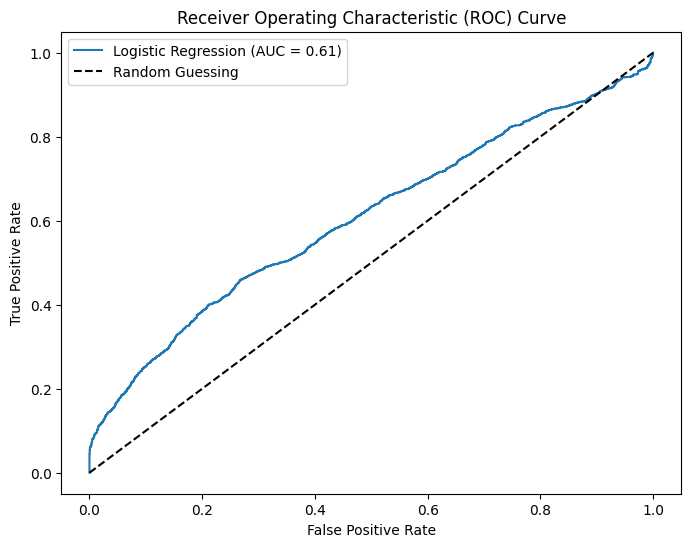

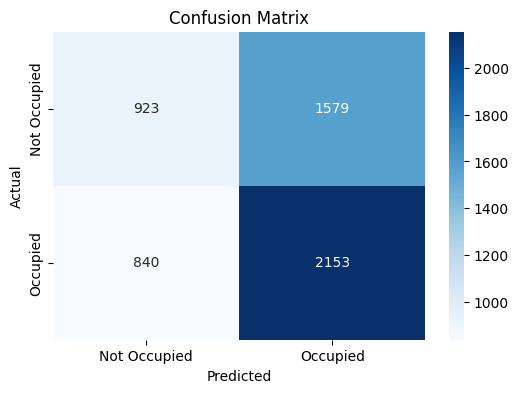

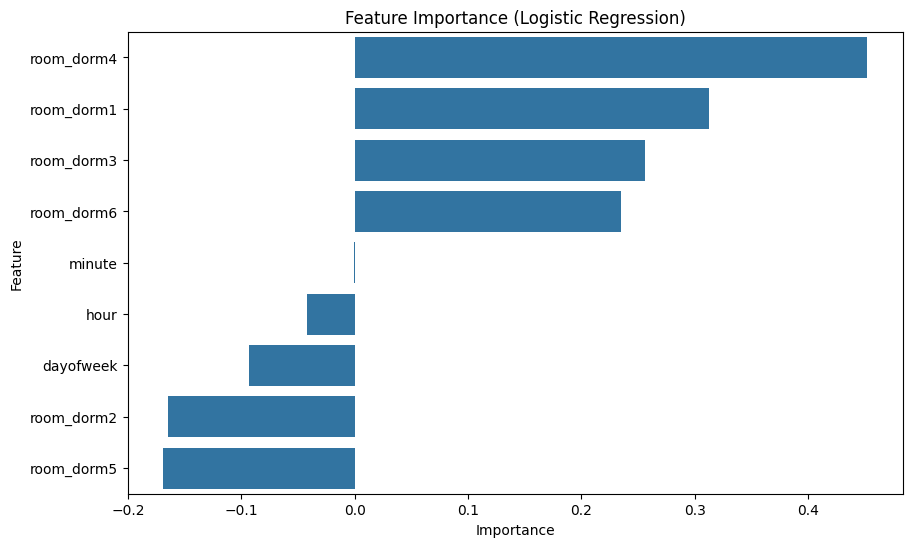

In [64]:
# Plotting Performance:

# 1. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Random guessing baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Occupied', 'Occupied'], 
            yticklabels=['Not Occupied', 'Occupied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3. Feature Importance (for Logistic Regression)
# (Note: Feature importance for Logistic Regression is based on coefficients)
if hasattr(model, 'coef_'):
    feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance (Logistic Regression)')
    plt.show()

else:
    print("Feature importance is not available for this model.")